# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning I</font>

# Convolutional Neural Networks (CNNs)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


## Classificação de Imagens de Satélites com Redes Neurais Convolucionais

### Definição do Projeto

Inteligência Artificial Para Classificação de Imagens de Satélites

A cada minuto, o mundo perde uma área de floresta do tamanho de 48 campos de futebol. E o desmatamento na Bacia Amazônica responde pela maior parcela, contribuindo para a redução da biodiversidade, perda de habitat, mudança climática e outros efeitos devastadores. Porém, melhores dados sobre a localização do desmatamento e invasão humana nas florestas podem ajudar os governos e as partes interessadas a responder com mais rapidez e eficácia.

A <a href="https://www.planet.com/">Planet</a>, projetista e construtora da maior constelação de satélites de geração de imagens da Terra, em breve estará coletando imagens diárias de toda a superfície terrestre com uma resolução de 3-5 metros. Embora uma pesquisa considerável tenha sido dedicada ao rastreamento de mudanças nas florestas, normalmente depende de imagens de resolução do tipo Landsat (30 metros) ou MODIS (250 metros). Isso limita sua eficácia em áreas onde predominam o desmatamento em pequena escala ou a degradação florestal.

Além disso, esses métodos existentes geralmente não podem diferenciar a degradação de florestas, entre causas humanas e causas naturais. imagens com resolução mais alta são excepcionalmente boas nisso, mas métodos robustos ainda não foram desenvolvidos para imagens da Planet.

> Neste trabalho, nosso objetivo é classificar imagens de satélite com condições atmosféricas e classes de cobertura / uso da terra, diferentes.

### Dataset

Os datasets com as imagens de satélite estão disponíveis gratuitamente no Kaggle:

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

As imagens são fornecidas em dois formatos: .tif e .jpg

Os arquivos .tif oferecem melhor qualidade de resolução, mas o dataset final fica com quase 40 GB. Sendo assim, para o propósito deste projeto (que é estudar as CNNs) usaremos as imagens em formato .jpg totalizando pouco mais de 1 GB.

Embora as imagens possam ser extraídas do link acima, já fizemos isso para você e organizamos no Titan (servidor da DSA). Mais detalhes quando carregarmos as imagens.

Abaixo uma descrição do formato das imagens.

As imagens foram separadas em chips, como esta abaixo. 

![title](imagens/chipdesc.jpg)

Os chips foram derivados a partir da análise de frame completo realizado pela Planet, usando os satélites de 4 bandas em órbita síncrona ao sol (SSO) e na Estação Espacial Internacional (ISS). O conjunto de chips usa o formato GeoTiff e cada um contém quatro faixas de dados: vermelho, verde, azul e infravermelho. A resposta espectral específica dos satélites pode ser encontrada na documentação da Planet. Cada um desses canais está no formato de número digital de 16 bits e atende às especificações do produto de cena orto analítica de quatro bandas Planet.

Os chips também estão disponíveis em formato JPG, o qual usaremos aqui no projeto.

**Criação do Dataset**

Para montar esse conjunto de dados, foi estabelecida uma especificação inicial dos fenômenos que deseja-se encontrar e incluir no conjunto final de dados. A partir dessa especificação inicial, criou-se uma "lista de desejos" de cenas na qual foi incluída um número aproximado de cenas necessárias para obter um número suficiente de chips para demonstrar o fenômeno. 

Esse conjunto inicial de cenas foi minuciosamente coletado pela equipe da Planet de Berlim usando o Planet Explorer. No total, esse conjunto inicial de cenas era de aproximadamente 1600 e cobria uma área de trinta milhões de hectares.

Esse conjunto inicial de cenas foi processado usando um processador personalizado para criar os chips jpg e tiff de 4 bandas. Qualquer chip que não tivesse um produto completo de quatro bandas foi omitido. Esse conjunto inicial de mais de 150.000 chips foi dividido em dois sets, um "hard" e um "easy". 

O conjunto fácil continha cenas que a equipe de Berlim identificou como tendo rótulos mais fáceis de identificar, como **floresta primária, agricultura, habitação, estradas, água e condições de nuvens**. O conjunto mais difícil de dados foi derivado de cenas nas quais a equipe de Berlim havia selecionado para o **cultivo, corte e queima de área de plantio, desmatamento, mineração e outros fenômenos**.

Os chips foram rotulados usando a plataforma <a href="https://appen.com/">Crowd Flower</a> e uma mistura de mão-de-obra coletiva e das equipes de Berlim e San Francisco. Embora tenha sido tomado o máximo cuidado para obter um conjunto de dados grande e bem rotulado, nem todos os rótulos em nosso conjunto de dados estão corretos. Governos de todo o mundo mantêm um grande número de analistas altamente treinados para revisar imagens e nem sempre conseguem concordar com o que está presente em uma determinada imagem de satélite.

Além disso, a abordagem comumente prescrita para rotular dados na comunidade GIS é usar dados reais para rotular cenas, o que é caro e demorado. Com isso em mente, os dados têm uma relação sinal / ruído razoavelmente alta e são suficientes para o treinamento. Dada a facilidade e conveniência da rotulagem de múltiplos arquivos, acredita-se que um conjunto de dados grande, relativamente barato e rapidamente rotulado é melhor que um conjunto de dados pequeno, mais definitivo, mas menos diversificado. 

A empresa <a href="https://www.sccon.com.br/">SCCON</a> também participou do projeto.

**Etiquetas (Labels ou Rótulos) de Classe**

Os rótulos das classes para esta tarefa foram escolhidos em colaboração com a equipe da Planet e representam um subconjunto razoável de fenômenos de interesse na bacia amazônica. Os rótulos podem ser divididos em três grupos: condições atmosféricas, fenômenos comuns de cobertura da terra / uso da terra e fenômenos raros de cobertura da terra / uso da terra. 

- Cada chip (patch) terá um e potencialmente mais de um rótulo atmosférico e zero ou mais rótulos comuns e raros. 

- Os chips rotulados como nublados não devem ter outros rótulos, mas pode haver erros de rotulagem.

![title](imagens/chips.jpg)

Você percebeu que teremos um projeto de alto nível! Então, vamos ao trabalho.

### Carregando os Pacotes

In [2]:
!nvidia-smi

Thu Dec 22 20:41:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.07    Driver Version: 527.27       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P2200        On   | 00000000:01:00.0  On |                  N/A |
| 53%   46C    P0    22W /  75W |   1006MiB /  5120MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [4]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip3 install -q -U watermark

In [5]:
# Imports para manipulação e visualização de dados
import os
import sys
import cv2
import csv
import math
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from tqdm import tqdm
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports para Deep Learning
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau

# Imports para avaliação de métricas e treinamento do modelo
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. 
# Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
%matplotlib inline

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

cv2       : 4.6.0
tensorflow: 2.9.1
sklearn   : 1.1.1
seaborn   : 0.11.2
numpy     : 1.23.1
matplotlib: 3.5.2
sys       : 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]
csv       : 1.0
keras     : 2.9.0
pandas    : 1.4.3
PIL       : 9.2.0



## Checando o Hardware Disponível no Servidor da DSA - CPU e GPUs

In [7]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10780859424937328686
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3737858868
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17252042411856065672
physical_device_desc: "device: 0, name: Quadro P2200, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


> Se por acaso não aparecer para você todas as GPUs, reinstale o TensorFlow:

In [8]:
# pip uninstall tensorflow
# pip install tensorflow

In [9]:
import tensorflow as tf
print("Número Disponível de GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Número Disponível de GPUs:  1


In [10]:
# Lista o código de cada GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Compreendendo e Carregando as Imagens

In [11]:
# Aqui especificamos o diretório com as imagens que estão disponíveis no Titan
imagens_treino = '/media/datasets/DeepLearningI/Cap08/CNN02/train-jpg'
imagens_teste = '/media/datasets/DeepLearningI/Cap08/CNN02/test-jpg'

In [12]:
# Aqui especificamos o diretório para o arquivo csv com as etiquetas das mais de 40 mil imagens
etiquetas_treino = '/media/datasets/DeepLearningI/Cap08/CNN02/labels/train_v2.csv'

In [13]:
# Aqui especificamos o diretório para o arquivo csv que vai gravar o resultado da classificação das imagens de teste
classificacao_etiquetas_teste = 'arquivos/resultado.csv'

## Preparando os Dados

In [14]:
# Vamos criar dataframes com os arquivos csv
dados_treino = pd.read_csv(etiquetas_treino)
dados_teste = pd.read_csv(classificacao_etiquetas_teste)

FileNotFoundError: [Errno 2] No such file or directory: '/media/datasets/DeepLearningI/Cap08/CNN02/labels/train_v2.csv'

In [ ]:
# Visualiza o dataframe
dados_treino.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
# Shape
dados_treino.shape

(40479, 2)

In [ ]:
# Visualiza o dataframe
dados_teste.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [ ]:
# Shape
dados_teste.shape

(61191, 2)

In [ ]:
# Agora incluímos em cada dataframe o nome de cada arquivo jpg
dados_treino['image_name'] = dados_treino['image_name'].astype(str) + '.jpg'
dados_teste['image_name'] = dados_teste['image_name'].astype(str) + '.jpg'

In [ ]:
# Vamos incluir nos dados de teste a lista de possíveis rótulos para cada imagem
dados_teste['tags'] = dados_teste['tags'].apply(lambda x: x.split(' '))

In [ ]:
# Visualiza o dataframe de treino
print("\nImagens de Treino:\n")
dados_treino.head()


Imagens de Treino:



,image_name,tags
0,train_0.jpg,haze primary
1,train_1.jpg,agriculture clear primary water
2,train_2.jpg,clear primary
3,train_3.jpg,clear primary
4,train_4.jpg,agriculture clear habitation primary road


In [ ]:
# Visualiza o dataframe de teste
print("\nImagens de Teste (começo do arquivo):\n")
dados_teste.head()


Imagens de Teste (começo do arquivo):



,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [ ]:
# Visualiza o dataframe de teste
print("\nImagens de Teste (final do arquivo):\n")
dados_teste.tail()


Imagens de Teste (final do arquivo):



,image_name,tags
61186,file_9995.jpg,"[primary, clear, agriculture, road, water]"
61187,file_9996.jpg,"[primary, clear, agriculture, road, water]"
61188,file_9997.jpg,"[primary, clear, agriculture, road, water]"
61189,file_9998.jpg,"[primary, clear, agriculture, road, water]"
61190,file_9999.jpg,"[primary, clear, agriculture, road, water]"


In [ ]:
# Vamos filtrar os dados de teste para reduzir o tempo total necessário para as previsões do modelo
dados_teste_final = dados_teste.iloc[:40479,]

In [ ]:
# O que sobrar colocamos em outro dataframe para facilitar a organização
dados_teste_restante = dados_teste.iloc[40479:,]

In [ ]:
# Shape
dados_teste_final.shape

(40479, 2)

In [ ]:
# Shape
dados_teste_restante.shape

(20712, 2)

In [ ]:
# Deleta o dataset de teste original para reduzir consumo de memória RAM do computador
del dados_teste

## Divisão das Imagens e Labels Para Treinamento

In [ ]:
# Vamos dividir os dados de treino em X (imagens) e y (label) e criar um array numpy
X_imagens_treino = np.array(dados_treino['image_name'].tolist())
X_imagens_treino.reshape((X_imagens_treino.shape[0], 1))
y_labels_treino = np.array(dados_treino['tags'].tolist())

In [ ]:
# X
X_imagens_treino

array(['train_0.jpg', 'train_1.jpg', 'train_2.jpg', ...,
       'train_40476.jpg', 'train_40477.jpg', 'train_40478.jpg'],
      dtype='<U15')

In [ ]:
# Shape
X_imagens_treino.shape

(40479,)

In [ ]:
# y
y_labels_treino

array(['haze primary', 'agriculture clear primary water', 'clear primary',
       ..., 'agriculture clear primary', 'agriculture clear primary road',
       'agriculture cultivation partly_cloudy primary'], dtype='<U92')

In [ ]:
# Shape
y_labels_treino.shape

(40479,)

In [ ]:
# Existem 17 labels e cada imagem está marcada com múltiplos labels
# Vamos imprimir a lista de labels exclusivos

# Lista para os labels
labels = []

# Loop pelas tags e retorna elementos únicos
for tag in dados_treino['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)

In [ ]:
# Ordena os labels
labels.sort()

# Print
print('\nClasses Únicas:', len(labels))
print('\nNomes das Classes:', labels)


Classes Únicas: 17

Nomes das Classes: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


## Escolhendo a Resolução Ideal das Imagens Para o Treinamento do Modelo

> Vamos checar agora a resolução das imagens e definir com qual resolução iremos trabalhar.

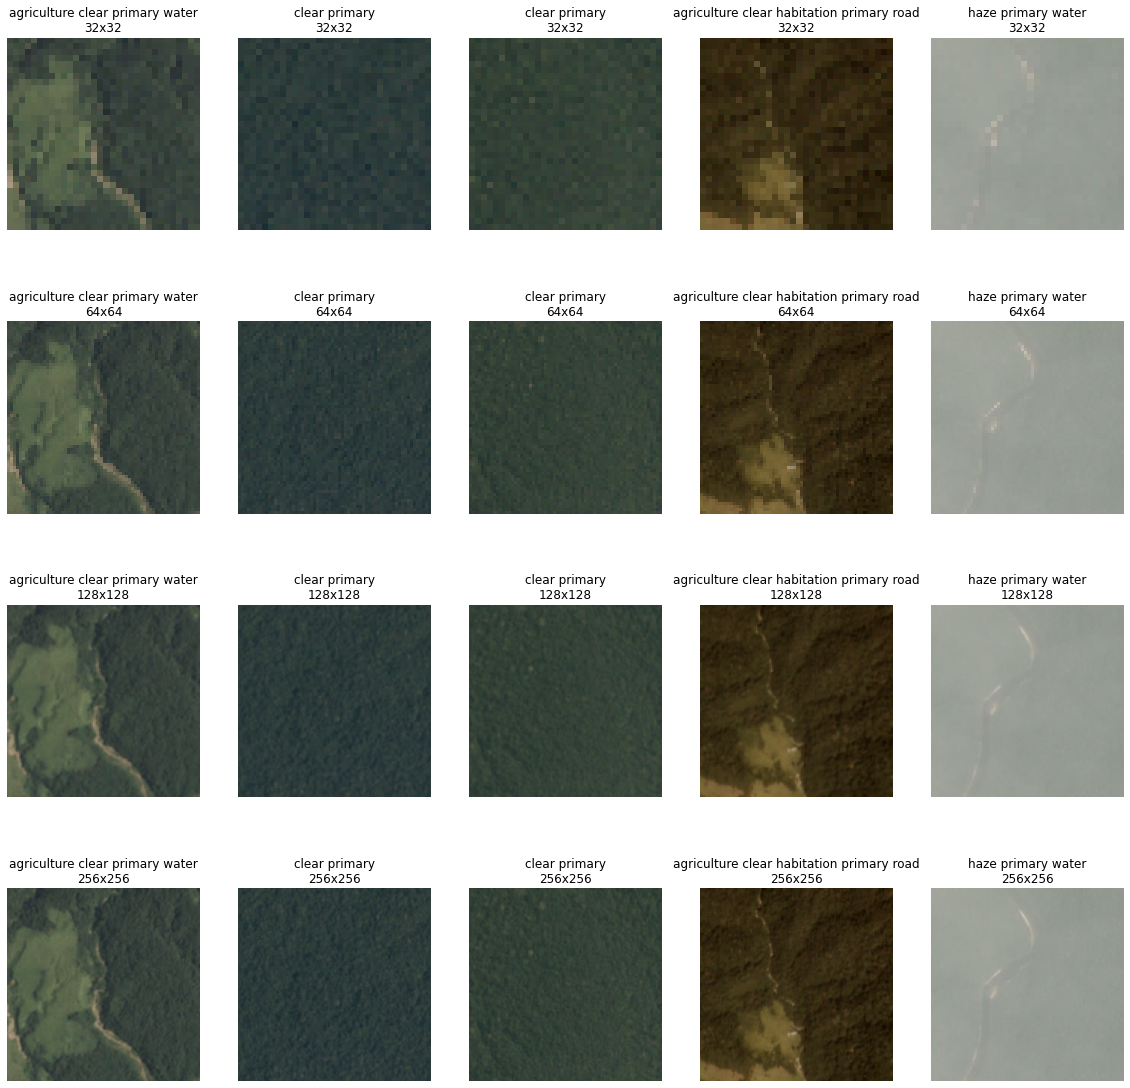

In [ ]:
# Loop pelas imagens para checar a qualidade de resolução

# Tamanho da figura
plt.figure(figsize = (20, 20))

# Lista de resoluções
res = [32, 64, 128, 256]

# Número de imagens
num_imagens = 5

# Todas as imagens tem o mesmo tamanho, mas vamos aplicar o resize com OpenCV e avaliar qual resolução fica melhor
for i in range(len(res)):
    for j in range(num_imagens):
        img = cv2.imread(os.path.join(imagens_treino, dados_treino['image_name'][j + 1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), num_imagens, i * num_imagens + j + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(dados_treino['tags'][j + 1] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')
    
plt.show()

> As imagens 128x128 apresentam boa resolução e como o processamento será mais rápido que imagens 256x256, usaremos 128x128.

## Verificando a Distribuição dos Labels

> Agora vamos checar a distribuição dos labels.

In [ ]:
# Loop pelos labels de treino

# Dicionário para contagem de imagens por label
labels_count = {}

# Loop
for tag in dados_treino['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0

In [ ]:
# Extraímos o valor mínimo e máximo
min_label = min(labels_count, key = labels_count.get)
max_label = max(labels_count, key = labels_count.get)

In [ ]:
# Print
print(min_label + " é a classe com menor número de imagens: " + str(labels_count[min_label]))
print(max_label + " é a classe com maior número de imagens: " + str(labels_count[max_label]))

conventional_mine é a classe com menor número de imagens: 99
primary é a classe com maior número de imagens: 37512


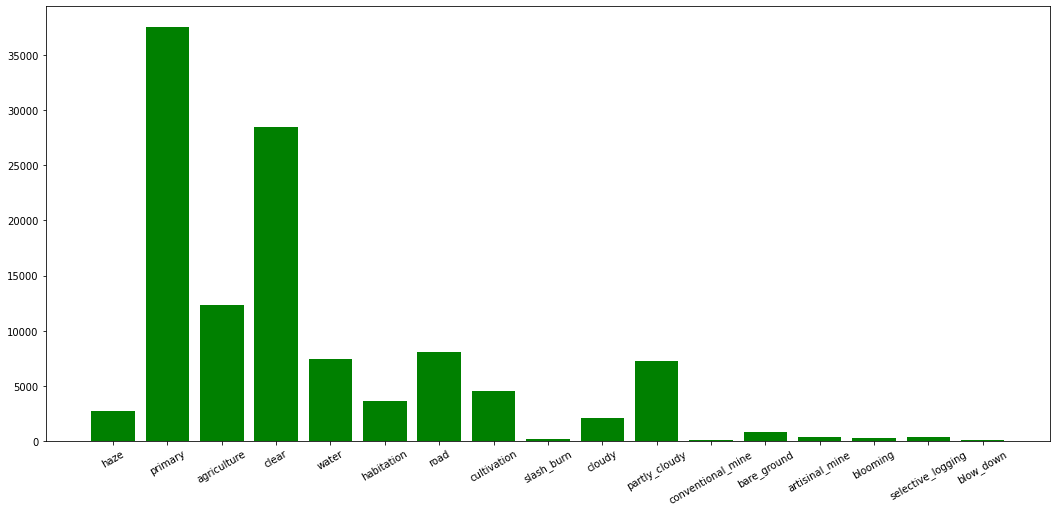

In [ ]:
# Graficamente fica mais fácil visualizar
# Tamanho da figura
plt.figure(figsize = (18, 8))

# Plot
plt.bar(range(len(labels_count)), list(labels_count.values()), align = 'center', color = 'green')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation = 30)
plt.show()

## Construção do Modelo

> Agora vamos preparar o modelo CNN.

In [ ]:
# Função para extrair e mostrar a curva de aprendizado do modelo
def curva_aprendizado(modelo, key = 'accuracy', ylim = (0.8, 1.01)):
    plt.figure(figsize = (15,6))
    plt.plot(modelo.history[key])
    plt.plot(modelo.history['val_' + key])
    plt.title('Curva de Aprendizado do Modelo')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['Treino', 'Teste'], loc = 'best')
    plt.show()

O escore F-beta é a média harmônica ponderada de precisão e recall, atingindo seu valor ótimo em 1 e seu pior valor em 0.

O parâmetro beta determina o peso do recall na pontuação combinada, sendo que beta < 1 empresta mais peso à precisão, enquanto beta > 1 favorece a recall (beta -> 0 considera apenas precisão, beta -> + inf apenas recall).

Vamos criar uma função para o escore F-beta e usar como métrica na validação do nosso modelo. O Scikit-learn tem uma função para essa métrica, mas a ideia é você compreender o que está sendo feito e por isso estamos criando a nossa. Aqui o link para o Scikit-learn:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

In [ ]:
# Função para o F-Beta Score
def fbeta_score(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [ ]:
# Hiperparâmetros do modelo

# Dimensões das imagens
INPUT_SHAPE = (128, 128, 3) 

# Tamanho do batch
BATCH_SIZE = 128

# Dropout
DROPOUT_RATE = 0.1

# Número de épocas
EPOCHS = 25

# Taxa de aprendizado
LR = 0.0001

# Taxa de decaimento
DECAY = 0.0001

# Número de folds para a validação cruzada
NFOLDS = 5 

# Número de cada fold durante o treinamento
# Iniciamos com 1 pois a variável será incrementada dentro do loop de treinamento
NUM_FOLD = 1

# Threshold de classificação das imagens
# A função sigmóide entrega probabilidades e definimos o limite para uma classe ou outra
THRES = [0.2] * 17 

# Pasta onde salvaremos os modelos
PATH_MODELOS = 'modelos/'

# Pasta onde salvaremos qualquer arquivo
PATH_ARQUIVOS = 'arquivos/'

In [ ]:
# Arquitetura do Modelo CNN
def cria_modelo():
    
    model = Sequential([
        
        # Primeira camada convolucional com duas operações seguidas de convolução
        Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE),
        Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(DROPOUT_RATE),

        # Segunda camada convolucional com duas operações seguidas de convolução
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(DROPOUT_RATE),

        # Terceira camada convolucional com três operações seguidas de convolução
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(DROPOUT_RATE),

        # Quarta camada convolucional com três operações seguidas de convolução
        Conv2D(256, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(256, kernel_size = (3, 3), activation = 'relu'),
        Conv2D(256, kernel_size = (3, 3), activation = 'relu'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(DROPOUT_RATE),

        Flatten(),

        Dense(17, activation = 'sigmoid') 
    ])

    # Otimizador Adam
    optimizer = Adam(LR, decay = DECAY)

    return model

In [ ]:
# Cria o modelo
modelo = cria_modelo()

Rede Neural Convolucional em Ação:

https://www.cs.ryerson.ca/~aharley/vis/conv/

In [ ]:
# Limpa a sessão e imprime o sumário do modelo
clear_session()
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

## Treinamento do Modelo com Validação Cruzada

> Vamos executar o treinamento usando validação cruzada.

In [ ]:
# Lista vazia para as previsões em teste
y_teste = []

In [ ]:
# Número de folds
folds = KFold(n_splits = NFOLDS, shuffle = True, random_state = 1).split(X_imagens_treino, y_labels_treino)

In [ ]:
%%time

# Loop de treinamento com validação cruzada
for train_index, val_index in folds:
    
    print("\nIniciando o Treinamento do Fold", NUM_FOLD)
    
    # Preparamos os dados de treino
    X_train_files_fold = X_imagens_treino[train_index]
    y_train_fold = y_labels_treino[train_index]
    
    # Preparamos os dados de validação
    X_val_files_fold = X_imagens_treino[val_index]
    y_val_fold = y_labels_treino[val_index]
    
    # Convertemos tudo em dataframe
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    # Precisamos dos labels para avaliar as previsões do modelo
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    print("\nDimensões dos Dados de Treino:", len(train_df))
    
    # Ajusta as imagens de treino
    # Mais detalhes em: https://keras.io/preprocessing/image/
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       horizontal_flip = True,
                                       vertical_flip = True)
    
    # Prepara o dataset de imagens de treino
    # Mais detalhes em: https://keras.io/preprocessing/image/
    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                        directory = imagens_treino,
                                                        x_col = 'image_name',
                                                        y_col = 'tags',
                                                        target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]), # 128 x 128
                                                        class_mode = 'categorical',
                                                        batch_size = BATCH_SIZE,
                                                        classes = labels,)
    
    print("\nDimensões dos Dados de Validação:", len(val_df))
    
    # Ajusta as imagens de validação
    # Mais detalhes em: https://keras.io/preprocessing/image/
    val_datagen = ImageDataGenerator(rescale = 1./255)
    
    # Prepara o dataset de imagens de validação
    # Mais detalhes em: https://keras.io/preprocessing/image/
    val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    directory = imagens_treino,
                                                    x_col = 'image_name',
                                                    y_col = 'tags',
                                                    target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]), # 128 x 128
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE,
                                                    classes = labels,)
    
    print("\nDimensões dos Dados de Teste:", len(dados_teste_final))
    
    # Ajusta as imagens de teste
    # Mais detalhes em: https://keras.io/preprocessing/image/
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    # Prepara o dataset de imagens de teste
    # Mais detalhes em: https://keras.io/preprocessing/image/
    test_generator = test_datagen.flow_from_dataframe(dados_teste_final,
                                                      directory = imagens_teste,
                                                      x_col = 'image_name',
                                                      y_col = 'tags',
                                                      target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1]), # 128 x 128
                                                      class_mode = 'categorical',
                                                      batch_size = BATCH_SIZE,
                                                      classes = labels,
                                                      shuffle = False,)
    
    # Limpa a sessão (libera a memória da GPU)
    clear_session()
    
    # Cria o modelo
    modelo_cnn_satelite = cria_modelo()
    
    # Taxa de aprendizagem para o otimizador Adam
    adam = Adam(learning_rate = LR)
    
    # Define a função de perda (loss)
    func_loss = 'binary_crossentropy'
    
    # Compila o modelo
    modelo_cnn_satelite.compile(optimizer = adam, loss = func_loss, metrics = [fbeta_score, 'accuracy'])
    
    # Caminho para salvar o modelo em cada fold (escolheremos o melhor)
    modelo_fold_salvo = os.path.join(PATH_MODELOS, 'pesos_fold_' + str(NUM_FOLD) + '.h5')
    
    # Callbacks para monitoramento do modelo e redução gradual da taxa de aprendizagem
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
    callbacks = [ModelCheckpoint(modelo_fold_salvo, 
                                 monitor = 'fbeta_score', 
                                 save_best_only = True, 
                                 mode = 'max'),
                 ReduceLROnPlateau(monitor = 'loss', 
                                   factor = 0.1, 
                                   patience = 3, 
                                   mode = 'min', 
                                   min_lr = 0.000001,
                                   verbose = 1)]
    
    # Treina o modelo
    modelo_cnn_satelite.fit_generator(train_generator, 
                                      epochs = EPOCHS, 
                                      validation_data = val_generator, 
                                      callbacks = callbacks)

    # Carrega o modelo que foi salvo em disco
    modelo_cnn_satelite.load_weights(modelo_fold_salvo)

    # Previsões com o modelo
    print("\nModelo fazendo a classificação nos dados de teste. Seja paciente e aguarde...")
    previsao_teste = modelo_cnn_satelite.predict_generator(test_generator)
    
    # Armazena o resultado
    y_teste.append(previsao_teste)
    
    # Incrementa num_fold para salvar o próximo modelo na validação cruzada
    print("\nTérmino do Fold ", NUM_FOLD, " da Validação Cruzada.")
    NUM_FOLD += 1

print("\nTreinamento Concluído.")


Iniciando o Treinamento do Fold 1

Dimensões dos Dados de Treino: 32383
Found 32383 validated image filenames belonging to 17 classes.

Dimensões dos Dados de Validação: 8096
Found 8096 validated image filenames belonging to 17 classes.

Dimensões dos Dados de Teste: 40479
Found 40479 validated image filenames belonging to 17 classes.
Epoch 1/25
253/253 [==============================] - 152s 602ms/step - loss: 0.2766 - fbeta_score: 0.5452 - accuracy: 0.9030 - val_loss: 0.2300 - val_fbeta_score: 0.5863 - val_accuracy: 0.9122
Epoch 2/25
253/253 [==============================] - 146s 576ms/step - loss: 0.2177 - fbeta_score: 0.6129 - accuracy: 0.9143 - val_loss: 0.1973 - val_fbeta_score: 0.6298 - val_accuracy: 0.9183
Epoch 3/25
253/253 [==============================] - 147s 581ms/step - loss: 0.2022 - fbeta_score: 0.6426 - accuracy: 0.9200 - val_loss: 0.1943 - val_fbeta_score: 0.6615 - val_accuracy: 0.9249
Epoch 4/25
253/253 [==============================] - 145s 573ms/step - loss: 0.

253/253 [==============================] - 147s 580ms/step - loss: 0.1442 - fbeta_score: 0.7527 - accuracy: 0.9435 - val_loss: 0.1587 - val_fbeta_score: 0.7735 - val_accuracy: 0.9445
Epoch 15/25
253/253 [==============================] - 146s 575ms/step - loss: 0.1432 - fbeta_score: 0.7541 - accuracy: 0.9440 - val_loss: 0.1339 - val_fbeta_score: 0.7739 - val_accuracy: 0.9451
Epoch 16/25
253/253 [==============================] - 146s 576ms/step - loss: 0.1418 - fbeta_score: 0.7569 - accuracy: 0.9446 - val_loss: 0.1293 - val_fbeta_score: 0.7700 - val_accuracy: 0.9462
Epoch 17/25
253/253 [==============================] - 147s 581ms/step - loss: 0.1405 - fbeta_score: 0.7587 - accuracy: 0.9450 - val_loss: 0.0942 - val_fbeta_score: 0.7727 - val_accuracy: 0.9436
Epoch 18/25
253/253 [==============================] - 145s 573ms/step - loss: 0.1388 - fbeta_score: 0.7617 - accuracy: 0.9458 - val_loss: 0.0982 - val_fbeta_score: 0.7714 - val_accuracy: 0.9485
Epoch 19/25
253/253 [================

Epoch 16/25
253/253 [==============================] - 146s 577ms/step - loss: 0.1396 - fbeta_score: 0.7597 - accuracy: 0.9447 - val_loss: 0.1447 - val_fbeta_score: 0.7641 - val_accuracy: 0.9462
Epoch 17/25
253/253 [==============================] - 147s 581ms/step - loss: 0.1387 - fbeta_score: 0.7613 - accuracy: 0.9457 - val_loss: 0.1385 - val_fbeta_score: 0.7715 - val_accuracy: 0.9471
Epoch 18/25
253/253 [==============================] - 145s 574ms/step - loss: 0.1373 - fbeta_score: 0.7640 - accuracy: 0.9458 - val_loss: 0.1304 - val_fbeta_score: 0.7856 - val_accuracy: 0.9477
Epoch 19/25
253/253 [==============================] - 145s 574ms/step - loss: 0.1355 - fbeta_score: 0.7671 - accuracy: 0.9468 - val_loss: 0.1494 - val_fbeta_score: 0.7920 - val_accuracy: 0.9486
Epoch 20/25
253/253 [==============================] - 146s 576ms/step - loss: 0.1342 - fbeta_score: 0.7694 - accuracy: 0.9471 - val_loss: 0.1256 - val_fbeta_score: 0.7891 - val_accuracy: 0.9497
Epoch 21/25
253/253 [====

## Carrega o Modelo Salvo

In [ ]:
# Caminho para o modelo treinado
model_path_of_fold = os.path.join(PATH_MODELOS, 'pesos_fold_' + str(NUM_FOLD - 1) + '.h5')

In [ ]:
# Cria o modelo
modelo_final = cria_modelo()

In [ ]:
# Carrega o modelo salvo
modelo_final.load_weights(model_path_of_fold)

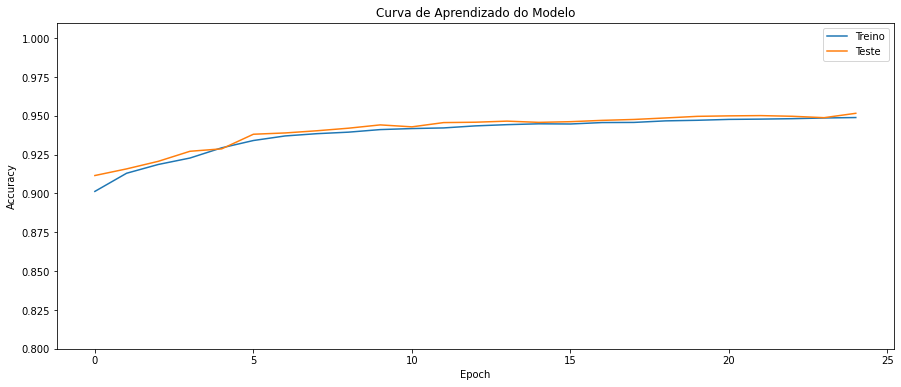

In [ ]:
# Plot da performance do modelo
curva_aprendizado(modelo_cnn_satelite.history)

O modelo tem ótima performance e o aprendizado foi lento. Poderíamos aumentar um pouco a taxa de aprendizado e treinar por mais épocas a fim de aumentar ainda mais a acurácia. Vou deixar isso com você.

## Resultado do Treinamento e Classificação das Imagens

In [ ]:
# O item y_teste tem todas as previsões nos dados de teste para cada fold da validação cruzada
len(y_teste)

5

In [ ]:
# Cria um array para os resultados de 1 fold da validação cruzada
resultado = np.array(y_teste[0])

In [ ]:
# Visualiza o resultado de 1 fold da validação cruzada
resultado

array([[3.58537026e-02, 1.15087430e-03, 2.74071121e-03, ...,
        1.06197447e-02, 1.62826444e-03, 4.93933558e-02],
       [6.93802312e-02, 1.10839121e-03, 1.89726776e-03, ...,
        1.71465091e-02, 1.46847568e-03, 4.84707914e-02],
       [1.15033634e-01, 1.32205756e-03, 2.07197107e-03, ...,
        7.18102601e-05, 1.11096841e-03, 9.87202600e-02],
       ...,
       [1.28187209e-01, 3.08408635e-04, 5.84577210e-04, ...,
        1.44266465e-04, 6.78103126e-04, 9.32235867e-02],
       [9.32165861e-01, 1.80980866e-03, 2.02542841e-02, ...,
        5.01354458e-03, 1.23906862e-02, 1.58686966e-01],
       [5.99018559e-02, 6.51527080e-04, 3.68372235e-03, ...,
        6.84326887e-03, 1.73138711e-03, 9.66413543e-02]], dtype=float32)

In [ ]:
# Converte o array em dataframe e visualiza o resultado
resultado_df = pd.DataFrame(resultado, columns = labels)
resultado_df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.035854,0.001151,0.002741,3.312169e-02,0.004185,0.982465,0.000044,0.000278,0.023750,0.005646,0.000627,0.013735,0.999645,0.023195,0.010620,0.001628,0.049393
1,0.069380,0.001108,0.001897,2.924577e-02,0.007014,0.902134,0.000004,0.000149,0.065861,0.009277,0.000077,0.106229,0.999982,0.030755,0.017147,0.001468,0.048471
2,0.115034,0.001322,0.002072,1.965914e-05,0.000094,0.001064,0.016263,0.000399,0.030340,0.010436,0.000264,0.976215,0.983666,0.075785,0.000072,0.001111,0.098720
3,0.017205,0.000190,0.000708,1.400888e-02,0.000946,0.980363,0.000010,0.000054,0.012234,0.002051,0.000106,0.016535,0.999901,0.010341,0.003278,0.000325,0.023448
4,0.054526,0.000048,0.000135,9.120800e-08,0.000002,0.000796,0.420501,0.000011,0.005659,0.007255,0.000865,0.568739,0.532211,0.034072,0.000003,0.000026,0.078662


In [ ]:
# Shape
resultado_df.shape

(40479, 17)

Na tabela acima, cada linha é uma imagem e cada coluna uma classe. Cada coluna representa o score (pontuação) de classe para aquela imagem. Tudo isso para 1 único fold.

Vamos calcular a média dos resultados obtidos da validação cruzada com k (5) folds.

In [ ]:
# Loop para abastecer o array
for i in range(1, NFOLDS):
    resultado += np.array(y_teste[i])
    resultado /= NFOLDS

In [ ]:
# Converte o array em dataframe
resultado_df_final = pd.DataFrame(resultado, columns = labels)
resultado_df_final.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.017726,0.000241,0.001418,0.007395,0.002265,0.245403,0.000015,0.000047,0.013692,0.001906,0.000832,0.004331,0.251142,0.006566,0.002542,0.000602,0.021365
1,0.025142,0.000216,0.000907,0.015320,0.006049,0.243286,0.000001,0.000024,0.037599,0.003390,0.000075,0.010230,0.251197,0.006217,0.006709,0.001237,0.018200
2,0.049017,0.000511,0.001105,0.000022,0.000167,0.000125,0.000939,0.000391,0.034046,0.002138,0.000080,0.249998,0.249673,0.015629,0.000184,0.000667,0.039647
3,0.020377,0.000238,0.000840,0.009568,0.001577,0.188609,0.000002,0.000036,0.017641,0.001785,0.000045,0.081648,0.251196,0.008114,0.003946,0.000404,0.016709
4,0.031166,0.000176,0.000720,0.000010,0.000020,0.001138,0.109564,0.000060,0.009219,0.003895,0.001106,0.164217,0.146160,0.014621,0.000057,0.000089,0.025342


Agora sim, a tabela acima representa as previsões finais do modelo. Vamos salvar isso no arquivo csv.

## Gravando e Apresentando o Resultado Final

In [ ]:
# Gravando apenas as previsões
resultado_df_final.to_csv(PATH_ARQUIVOS + 'resultado_previsoes.csv')

In [ ]:
# Gravando as previsões e as classes sugeridas em teste

# Lista para as previsões
preds = []

# Loop para extrair as previsões
for i in range(resultado_df_final.shape[0]):
    a = resultado_df_final.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis = 1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [ ]:
# Gravando os labels originais e as previsões do modelo em formato csv
# Dica: esse arquivo pode ser submetido ao Kaggle se você desejar
dados_teste_final['preds'] = preds
dados_teste_final.to_csv(PATH_ARQUIVOS + 'resultado_final.csv', index = False)

In [ ]:
# Visualizando 20 previsões do modelo
dados_teste_final.head(20)

,image_name,tags,preds
0,test_0.jpg,"[primary, clear, agriculture, road, water]",clear primary
1,test_1.jpg,"[primary, clear, agriculture, road, water]",clear primary
2,test_2.jpg,"[primary, clear, agriculture, road, water]",partly_cloudy primary
3,test_3.jpg,"[primary, clear, agriculture, road, water]",primary
4,test_4.jpg,"[primary, clear, agriculture, road, water]",
5,test_5.jpg,"[primary, clear, agriculture, road, water]",clear primary
6,test_6.jpg,"[primary, clear, agriculture, road, water]",primary
7,test_7.jpg,"[primary, clear, agriculture, road, water]",clear habitation road
8,test_8.jpg,"[primary, clear, agriculture, road, water]",clear primary
9,test_9.jpg,"[primary, clear, agriculture, road, water]",primary


# Fim